In [68]:
import networkx as nx
import pandas as pd
from scipy import stats
from collections import Counter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from functions import load_graph_1, load_graph_2, top_N_filter

graph1 = load_graph_1()
graph2 = load_graph_2()

## Functionality and Viz 1

In [64]:
def func1(graph, type, N=-1):
    graph = top_N_filter(graph, N)
    
    node_number = len(graph)
    if type==1:
        collab = dict(graph.degree)
    elif type==2:
        collab = dict(filter(lambda k: graph.nodes[k[0]]['type'] == 'comic', dict(graph.degree).items()))
    
    density = nx.density(graph)
    
    degree_count = Counter(dict(graph.degree).values())
    probs = np.array(list(degree_count.values()))/sum(degree_count.values())
    values = np.array(list(degree_count.keys()))
    pmf = stats.rv_discrete(name='degree', values=(values, probs))
    avg = pmf.mean()
    
    p95 = pmf.ppf(.95)
    hubs = [n for n,v in graph.degree if v >= p95]
    
    is_dense = density > 0.05
    
    return node_number, collab, density, pmf, avg, hubs, is_dense

In [132]:
def viz1(graph, type, N=-1):
    node_number, collab, density, pmf, avg, hubs, is_dense = func1(graph, type, N)
    
    # print table
    print( '| Number of nodes | Density | Average degree | Is dense |')
    print( '|-----------------|---------|----------------|----------|')
    print(f'| {node_number:15} | {round(density, 3):7} | {round(avg, 3):14} | {is_dense:8} |')
    
    display(pd.DataFrame(hubs, columns=['Hubs']))
    
    # A plot depicting the number of collaborations of each hero
    c = pd.DataFrame.from_dict(collab, orient='index').sort_values(by=0, ascending=False)
    plt.bar(x = c.index, height = c[0])
    plt.title('# of heroes')
    if len(c) > 10:
        plt.xticks([])
    plt.show()
    
    # A plot depicting the degree distribution of the network
    xk = range(*pmf.support())
    print(xk)
    plt.plot(xk, pmf.pmf(xk), 'ro', ms=5, mec='orchid')
    plt.title('Degree\'s PMF distribution')
    plt.vlines(xk, 0, pmf.pmf(xk), colors='orchid', lw=3)
    plt.show()

| Number of nodes | Density | Average degree | Is dense |
|-----------------|---------|----------------|----------|
|            1000 |   0.123 |        123.136 |        1 |


,Hubs
0,ANGEL/WARREN KENNETH
1,ANT-MAN/DR. HENRY J.
2,BEAST/HENRY &HANK& P
3,BLACK KNIGHT V/DANE
4,BLACK PANTHER/T'CHAL
5,BLACK WIDOW/NATASHA
6,"CAGE, LUKE/CARL LUCA"
7,CAPTAIN AMERICA
8,COLOSSUS II/PETER RA
9,CRYSTAL [INHUMAN]


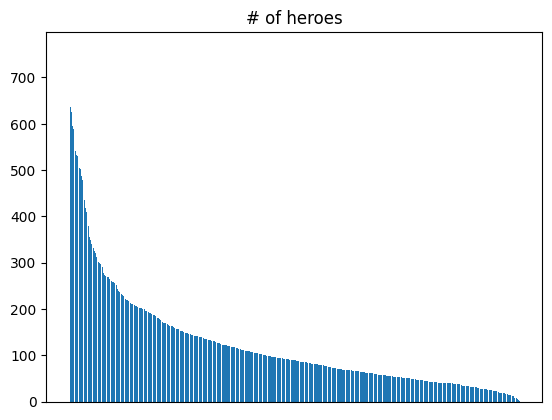

range(2, 760)


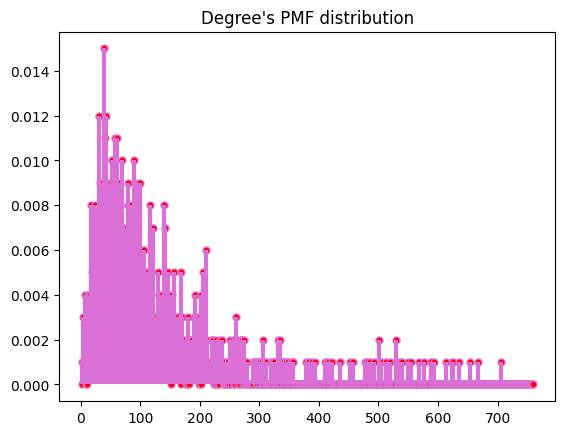

In [133]:
viz1(graph1, 1, 1000)

| Number of nodes | Density | Average degree | Is dense |
|-----------------|---------|----------------|----------|
|           13648 |   0.001 |         11.121 |        0 |


,Hubs
0,COC 1
1,ABOMINATION/EMIL BLO
2,H2 278
3,SWII 7
4,ABSORBING MAN/CARL C
...,...
683,X-MAN/NATHAN GREY
684,YELLOW CLAW/TZING JA
685,ZABU
686,"ZARRKO, ARTHUR"


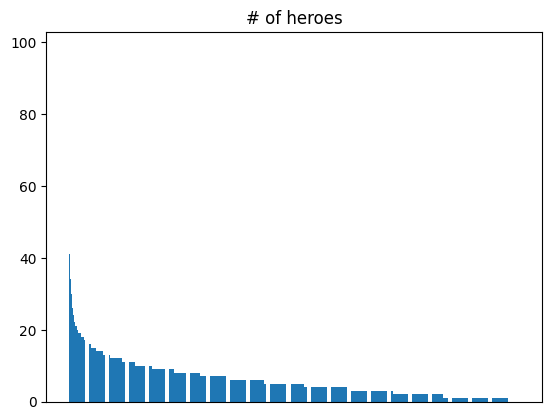

range(0, 1577)


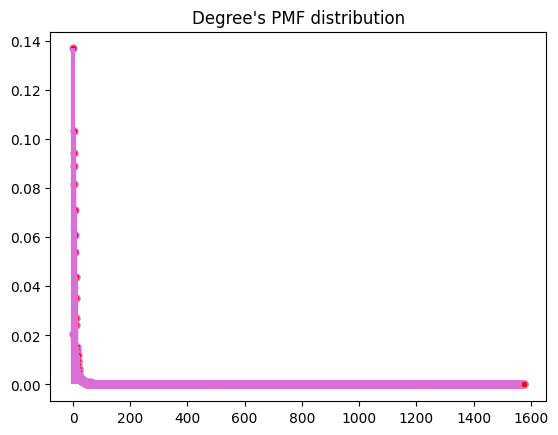

In [134]:
viz1(graph2, 2, 1000)